# HW-6 RF & C50
Wyatt Blair

SID: 10420296

2/26/24


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from tqdm.auto import tqdm
import json
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

/Users/wyatthenryblair/anaconda3/envs/torch20/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
dataset = pd.read_csv('../data/breast-cancer-wisconsin.csv', index_col='Sample')
dataset

,F1,F2,F3,F4,F5,F6,F7,F8,F9,Class
Sample,,,,,,,,,,
1000025,5,1,1,1,2,1,3,1,1,2
1002945,5,4,4,5,7,10,3,2,1,2
1015425,3,1,1,1,2,2,3,1,1,2
1016277,6,8,8,1,3,4,3,7,1,2
1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...
776715,3,1,1,1,3,2,1,1,1,2
841769,2,1,1,1,2,1,1,1,1,2
888820,5,10,10,3,7,3,8,10,2,4


In [3]:
dataset.replace('?', np.nan, inplace=True)
dataset.dtypes

F1        int64
F2        int64
F3        int64
F4        int64
F5        int64
F6       object
F7        int64
F8        int64
F9        int64
Class     int64
dtype: object

In [4]:
dataset['F6'] = dataset['F6'].astype(np.float_)
dataset.dtypes

F1         int64
F2         int64
F3         int64
F4         int64
F5         int64
F6       float64
F7         int64
F8         int64
F9         int64
Class      int64
dtype: object

In [5]:
target = 'Class'
features = dataset.columns.to_list(); features.remove(target)

train = dataset.sample(frac=0.8)
test = dataset.drop(train.index)

### In HW-5-CART I implemented the SingleCART and CART classes which will come in handy here. I have modified it slightly to handle random feature selection.

In [6]:
class SingleCART:

    def __init__(self, data, target, random_feature_selection=True):

        if isinstance(data, dict):
            data = pd.DataFrame(data)

        self.data = data
        self.target = target
        self.random_feature_selection = random_feature_selection

        self.features = data.columns.to_list(); self.features.remove(target)
        self.M = len(self.features)

        if random_feature_selection and self.M > 1:

            num_selected_features = np.random.randint(low=1, high=self.M)
            self.features = random.sample(self.features, k=num_selected_features)

        self.unique_feat_vals = {feat: list(self.data[feat].unique()) for feat in self.features}
        self.unique_target_vals = list(self.data[self.target].unique())

        self.H_system = self.system_entropy()
        self.H_splits = self.split_entropies()
        self.information_gains = self.calculate_information_gains()

        if len(self.information_gains) == 0:
            self.best_split = None
            self.data_splits = {}
        else:
            self.best_split = self.get_best_split()
            self.data_splits = self.split_data()

    def calc_probabilities(self, feature):

        unique_feat_vals = self.unique_feat_vals[feature]
        unique_target_vals = self.unique_target_vals

        counts = self.data[[feature, self.target]].groupby(self.target).value_counts()
        count_mat = pd.DataFrame(
            data=np.zeros((len(unique_feat_vals), len(unique_target_vals))),
            columns=unique_target_vals,
            index=unique_feat_vals
        )

        for (t, f), val in zip(counts.index, counts.values):
            count_mat[t][f] = val

        probability_mat = (count_mat.T / count_mat.sum(axis=1)).T
        probability_mat.sort_index(axis=1, inplace=True)
        probability_mat.sort_index(axis=0, inplace=True)

        return probability_mat

    def calc_gini(self):

        gini_frames = {}
        for feature in self.features:

            probabilities = self.calc_probabilities(feature)
            terms = probabilities ** 2
            gini = 1 - terms.sum(axis=1)

            gini_frames.update({feature: gini})
        
        
        # THIS PART OF THE CODE WAS GENERATED USING ChatGPT 4.0 with the following prompt:
        '''
        i have a dictionary in python where the keys are column headers and the values are dataframes. 
        the indices of the dataframes may not be the same. i want to create one large dataframe where 
        the index is a superset of all dataframe indices, the column headers are the keys from the 
        original dictionary, and the values are the values of the dataframe stored under the associated key.
        how would you implement this?
        '''

        # Step 1: Create a superset of all indices
        all_indices = set()
        for df in gini_frames.values():
            all_indices = all_indices.union(set(df.index))

        # Step 2: Initialize an empty DataFrame with the superset of indices
        gini_frame = pd.DataFrame(index=list(all_indices))

        # Step 3: Iterate through the dictionary and populate the new DataFrame
        for key, df in gini_frames.items():
            for idx in all_indices:
                if idx in df.index:
                    # Assuming each DataFrame has only one column, adjust if it has multiple
                    gini_frame.loc[idx, key] = df.loc[idx]
                else:
                    # Optional: Specify a placeholder for missing values
                    gini_frame.loc[idx, key] = None  # Or pd.NA, np.nan, etc.

        # ==========================================================================

        return gini_frame

    def get_best_gini_split(self):

        gini_frame = self.calc_gini()
        stacked_gini = gini_frame.stack()
        min_index = stacked_gini.idxmin()
        min_row_index, min_column_name = min_index

        return min_row_index, min_column_name

    def system_entropy(self):

        probabilities = self.data[self.target].value_counts() / self.data.shape[0]
        logs = np.log2(probabilities)
        terms = -logs * probabilities
        entropy_value = terms.sum()

        return entropy_value

    def split_entropy(self, feature):

        probabilities = self.calc_probabilities(feature)

        logs = np.log2(probabilities)
        logs.replace([np.inf, -np.inf], 0, inplace=True)

        feature_terms = -probabilities * logs
        feature_entropies = feature_terms.sum(axis=1)

        n = self.data.shape[0]
        likelihoods = self.data[feature].value_counts() / n

        terms = feature_entropies * likelihoods
        entropy_value = terms.sum()

        return entropy_value

    def split_entropies(self):

        return {
            feat: self.split_entropy(feat)
            for feat in self.features
        }
    
    def calculate_information_gains(self):

        return {
            feat: self.H_system - H_split 
            for feat, H_split in self.H_splits.items()
        }

    def get_best_split(self):

        return max(
            self.information_gains.items(), key=lambda x: x[1]
        )
    
    def split_data(self):
        
        best_split_feat, best_split_information_gain = self.best_split
        unique_vals = self.unique_feat_vals[best_split_feat]

        split_data = {
            val: self.data[self.data[best_split_feat] == val].drop(columns=best_split_feat).to_dict()
            for val in unique_vals
        }

        return split_data


In [7]:
class CART:

    def __init__(self, data: pd.DataFrame, target: str, random_feature_selection=True, min_datapoints_for_split=10):

        self.data = data
        self.target = target
        self.features = data.columns.to_list(); self.features.remove(target)

        self.random_feature_selection = random_feature_selection
        self.min_datapoints_for_split = min_datapoints_for_split

        self.tree = {}
        self.build_tree()

    def split(self, data: pd.DataFrame):

        single_cart = SingleCART(data=data, target=self.target, random_feature_selection=self.random_feature_selection)
        split_val, feature = single_cart.get_best_gini_split()

        split_func = lambda row: row[feature] <= split_val
        left = data[data.apply(split_func, axis=1)].drop(columns=feature)
        right = data.drop(index=left.index, columns=feature)

        split_dict = {
            'L': left,
            'R': right,
            'feature': feature,
            'split value': split_val,
            'L-Key': f"{feature} <= {split_val}",
            'R-Key': f"{feature} > {split_val}",
        }

        return split_dict
    
    def build_tree(self, data=None, tree=None):

        if data is None: 
            data = self.data
        
        if tree is None:
            tree = self.tree

        if data.empty: 
            return None

        if (list(data.columns) == [self.target]) or len(data.index) < self.min_datapoints_for_split:
            
            class_counts = data[self.target].value_counts().sort_values()

            if class_counts.empty: 
                return None
            else: 
                return class_counts.index[0]
        
        # elif len(data.index) < self.min_datapoints_for_split:

        #     class_counts = data[self.target].value_counts().sort_values()
        #     return class_counts.index[0]

        else:

            split_dict = self.split(data)

            left = self.build_tree(data=split_dict['L'], tree={})
            right = self.build_tree(data=split_dict['R'], tree={})

            if left is not None:
                tree.update({split_dict['L-Key']: left})
            if right is not None:
                tree.update({split_dict['R-Key']: right})

            return tree
    
    def convert_key_to_func(self, key):

        if '>' in key:

            split_str = key.split('>')
            feature, split_val = split_str[0].strip(), float(split_str[1].strip())

            split_func = lambda x: x[feature] > split_val
        
        elif '<=' in key:

            split_str = key.split('<=')
            feature, split_val = split_str[0].strip(), float(split_str[1].strip())

            split_func = lambda x: x[feature] <= split_val  
        
        else:

            raise RuntimeError(f'Could not find inequality operator in key: "{key}"')
        
        return split_func

    def predict(self, x):

        node = self.tree
        max_depth = len(self.features);  iter_count = 0

        while isinstance(node, dict) and iter_count <= max_depth:
            for key in node.keys():

                if self.convert_key_to_func(key)(x): 
                    node = node[key]
            
            iter_count += 1

        return node


In [8]:
class RandomForest:

    def __init__(self, data: pd.DataFrame, target, num_estimators: int, min_datapoints_for_split: int):

        self.data = data
        self.features = self.data.columns.to_list(); self.features.remove(target)
        self.target = target

        self.X = self.data[self.features]
        self.y = self.data[self.target]

        self.num_estimators = num_estimators
        
        self.N = len(self.y.index)
        self.M = len(self.features)
        self.min_datapoints_for_split = min_datapoints_for_split

        self.out_of_bag_accuracies = {}
        self.decision_trees = {}
        self.bootstrapped_indices = {}

        for i in tqdm(range(num_estimators), total=num_estimators, desc='Training decision trees'):
            tree, bootstrapped_indices = self.make_tree()

            self.decision_trees.update({
                i: tree
            })
            
            self.bootstrapped_indices.update({
                i: bootstrapped_indices
            })

        # self.save_trees()

    def save_trees(self):
        # save the trees!
        # i am the lorax, i speak for the trees
        
        for i, cart in self.decision_trees.items():
            with open(f'./decision_trees/tree_{i}.json', 'w') as f:
                json.dump(cart.tree, fp=f, indent=4)

    def bootstrap_sample(self):

        bootstrapped_data = self.data.sample(self.N, replace=True)
        return bootstrapped_data

    def calc_oob_acc(self):
        
        for i, tree in self.decision_trees.items():

            bootstrap_data = self.data.loc[self.bootstrapped_indices[i]]
            out_of_bag_data = self.data.drop(index=bootstrap_data.index)

            # assess out-of-bag accuracy
            out_of_bag_data['prediction'] = out_of_bag_data[self.features].apply(tree.predict, axis=1)
            out_of_bag_data['correct'] = out_of_bag_data[self.target] == out_of_bag_data['prediction']
            out_of_bag_accuracy = out_of_bag_data['correct'].value_counts()[True] / (len(out_of_bag_data.index))

            self.out_of_bag_accuracies.update({
                    i: out_of_bag_accuracy
            })
        
        return self.out_of_bag_accuracies


    def make_tree(self):

        # bootstrap data
        bootstrap_data = self.bootstrap_sample()

        # train decision tree
        tree = CART(
            data=bootstrap_data, 
            target=self.target, 
            random_feature_selection=True, 
            min_datapoints_for_split=self.min_datapoints_for_split
        )
        
        return tree, bootstrap_data.index
    
    def predict(self, x):

        decisions = pd.Series([
            tree.predict(x)
            for tree in self.decision_trees.values()
        ])
        decision_counts = decisions.value_counts().sort_values()
        most_common_decision = decision_counts.index[0]

        return most_common_decision
        


## Do a param search to find optimal Random Forest

In [9]:
num_estimators_vals = [1, 2, 3, 4, 5, 10, 25, 50, 100]
min_datapoints_for_split_vals = [1, 5, 10, 50, 100]

accuracies = pd.DataFrame(
    data=np.zeros((len(num_estimators_vals), len(min_datapoints_for_split_vals)), dtype=np.float_),
    columns=min_datapoints_for_split_vals,
    index=num_estimators_vals
).sort_index()

forests = pd.DataFrame(
    data=np.zeros((len(num_estimators_vals), len(min_datapoints_for_split_vals))),
    columns=min_datapoints_for_split_vals,
    index=num_estimators_vals
).sort_index()


In [11]:
for num_estimators in num_estimators_vals:
    for min_datapoints_for_split in min_datapoints_for_split_vals:

        rf = RandomForest(
            data=train, 
            target='Class', 
            num_estimators=num_estimators, 
            min_datapoints_for_split=min_datapoints_for_split,
        )
        test['prediction'] = test[features].apply(rf.predict, axis=1)
        test['correct'] = test['prediction'] == test[target]
        accuracy = test['correct'].value_counts()[True] / len(test.index)

        accuracies[min_datapoints_for_split][num_estimators] = accuracy
        forests[min_datapoints_for_split][num_estimators] = rf

Training decision trees: 100%|██████████| 100/100 [00:20<00:00,  4.87it/s]


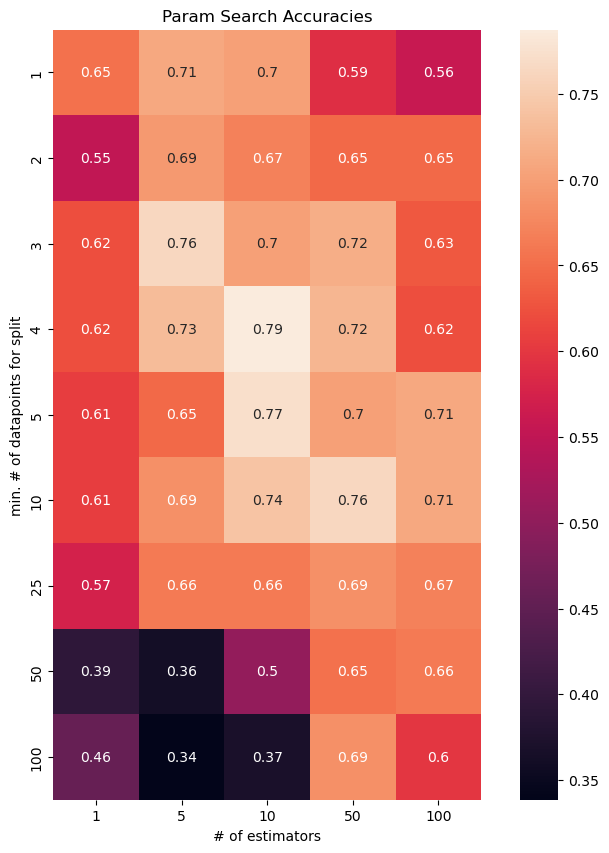

In [12]:
fig, ax = plt.subplots(1,1, figsize=(10,10))

sns.heatmap(accuracies, ax=ax, annot=True, square=True)

ax.set_xlabel('# of estimators')
ax.set_ylabel('min. # of datapoints for split')
ax.set_title('Param Search Accuracies')

plt.show()


In [23]:
best_col = accuracies.max().idxmax()
best_row = accuracies[best_col].idxmax()

param_search_results = {
    'best accuracy': accuracies.max().max(),
    'best # estimators': best_col,
    'best min # datapoints for split': best_row,
    'best forest': forests[best_col][best_row]
}

param_search_results

{'best accuracy': 0.7874015748031497,
 'best # estimators': 10,
 'best min # datapoints for split': 4,
 'best forest': <__main__.RandomForest at 0x168355ab0>}

In [24]:
param_search_results['best forest'].calc_oob_acc()

{0: 0.7914438502673797,
 1: 0.746031746031746,
 2: 0.7359550561797753,
 3: 0.7541899441340782}